In [1]:
!pip install tensorflow pandas tqdm scikit-learn gensim Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.7 MB/s eta 0:00:00


# LSTM Implementation

In this LSTM implementation endeavor, we looking into the implementation of LSTM-based model to do sentiment analysis for case below:

https://www.kaggle.com/code/kevinismail/training-lstm-sentiment-analysis-bahasa

This endeavor aim to create an LSTM model with high accuracy.

In [2]:
import tensorflow;

import pandas;
from sklearn.model_selection import train_test_split;
from tqdm import tqdm;
import re;

import json;

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory;

In [3]:
from google.colab import drive;
drive.mount("/content/drive");

Mounted at /content/drive


## Data Loading & Exploration

First is to load the dataset with pandas. The file separator is [TAB] so we set it to `\\t+`.

This part also explore the dataset.

In [4]:
dataframe = pandas.read_csv("/content/drive/MyDrive/Collab Dataset/nlp-dl-self-assignment/raw_dataset.csv", sep = "\\t+");


print("Data Profile Model");
print("============================================================");
print(dataframe.count());

sentiment_negative = len(dataframe[dataframe["sentimen"] == -1]);
sentiment_neutral = len(dataframe[dataframe["sentimen"] == 0]);
sentiment_positive = len(dataframe[dataframe["sentimen"] == 1]);
print(f"Data with sentiment negative (-1) \t: {sentiment_negative}");
print(f"Data with sentiment neutral (0)   \t: {sentiment_neutral}");
print(f"Data with sentiment positive (1)  \t: {sentiment_positive}");

dataframe.head()

<ipython-input-4-b221262af985>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataframe = pandas.read_csv("/content/drive/MyDrive/Collab Dataset/nlp-dl-self-assignment/raw_dataset.csv", sep = "\\t+");


Data Profile Model
sentimen    10806
Tweet       10806
dtype: int64
Data with sentiment negative (-1) 	: 2887
Data with sentiment neutral (0)   	: 5327
Data with sentiment positive (1)  	: 2592


,sentimen,Tweet
0,-1,lagu bosan apa yang aku save ni huhuhuhuhuhuhu...
1,-1,kita lanjutkan saja diam ini hingga kau dan ak...
2,1,doa rezeki tak putus inna haa zaa larizquna ma...
3,1,makasih loh ntar kita bagi hasil aku 99 9 sisa...
4,-1,aku tak faham betul jenis orang malaysia yang ...


# Defining Feature and Label

This part will define which is feature and which is label.

In [5]:
features = dataframe["Tweet"];
labels = dataframe["sentimen"];

## Dataset Pre-Processing

NLP / NLU cases are known as not easy dataset pre-processing. <br />
Imagine converting your text into numbers just to make computer understand what you try to do. <br />
Public dataset also challenging. <br />
I mean, what is this? Bahasa Indonesia? Javanese? Sundanese? Malay? English? How???

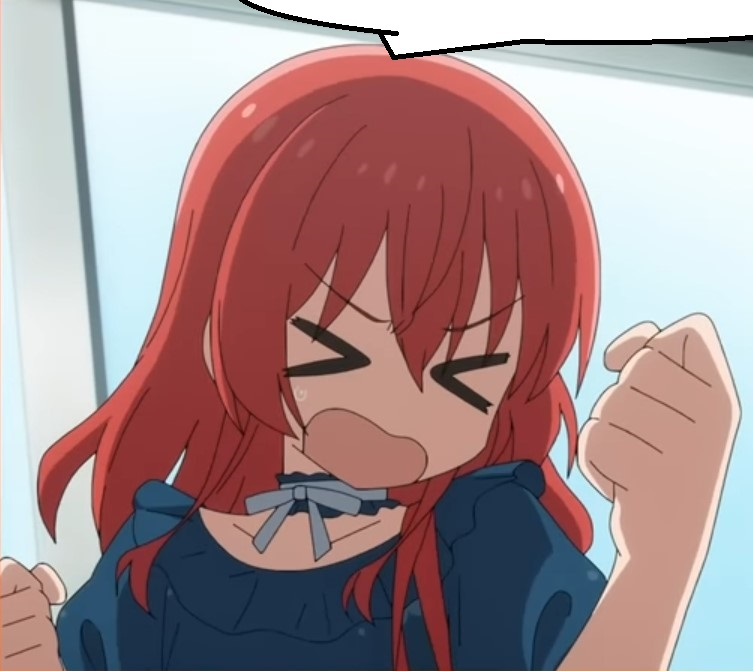
Enough the ranting, let's start with data normalization before we going for the actual pre-processing concept for NLU:

1. Make all words in the dataset lower case
2. Remove any punctuation characters
3. Remove Bahasa Indonesia stop words

In [6]:
# Call out step 1
features = features.str.lower();

# Call out step 2
def remove_punctuation (text: str):
    punct_regex = r'[^\w\s]';
    clean_text = re.sub(punct_regex, "", text);
    return clean_text;

features = features.apply(lambda x: remove_punctuation(x));

# Call out step 3
stopword_factory = StopWordRemoverFactory();
stopwords = stopword_factory.get_stop_words();

def remove_stopword (text: str):
    # Splice the sentence into words
    words = text.split();

    # If word in current loop is not available in stopwords array, then save it to clean_words
    clean_words = [i for i in words if i not in stopwords];

    # Unsplice words into one sentence.
    return " ".join(clean_words);

features = features.apply(lambda x: remove_stopword(x));


There are few things to complete within dataset pre-processing for NLU case:

### 1. Slang Word Standardization
We have such beautiful community that keep texting with slang words. In other word, not removing slang-words may cause problems when stemming. So, this part will replace all those slang words, into standard one.

But we also had beautiful community that provides such slang dataset.
https://github.com/louisowen6/NLP_bahasa_resources/tree/master

The algorithm of this task is as follow:

> 1. Load `combined_slang_words.json` file
> 2. Loop through features data <br />
> 2.1 Splice the sentence <br />
> 2.2 For every word within sentence <br />
> 2.2.1 If this word is found on slang, then replace it with standard one <br />
> 2.2.2 Else, ignore. <br />
> 2.3 Unsplice the sentence <br />
> 3. Save the data

In [7]:
slang_db = json.load(open("/content/drive/MyDrive/Collab Dataset/nlp-dl-self-assignment/resources/combined_slang_words.json", "r"));

def slang_word_standardizer(text: str):
    words = text.split();
    clean_words = [slang_db.get(i, i) for i in words];

    return " ".join(clean_words);

features = features.apply(lambda x: slang_word_standardizer(x));


### 2. Lexical Analysis

This step normalize your text. Kind of doing "standardization". This step will include *Stemming*.

#### Stemming

Bahasa Indonesia had so many unnormal words ruling. By mean *unnormal*:

| Unnormal word | Stemming result |
|---|---|
| Memberikan | beri |
| Perekonomian | ekonomi |
| Pertumbuhan | tumbuh |
| Membanggakan | bangga |

*Bare with me

#### Lemmatization
Unfortunately, Sastrawi haven't made for Lemmatization we will skip the lemmatization for now. But if this feature exists, I'll prefer this than just stemming.

In [8]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory;

factory = StemmerFactory();
stemmer = factory.create_stemmer();

tqdm.pandas();

# Apply stemmer
print("Stemming progress");
features = features.progress_apply(lambda x: stemmer.stem(x));

Stemming progress


100%|██████████| 10806/10806 [27:54<00:00,  6.45it/s]


### 3. Tokenization & Vectorization / Word Embedding

After Stemming, we will start into Tokenization & Vectorization.

#### Tokenization

Hence I got this sentence below:

"Hallo everynyan. How are you? Fine thank you. I wish I were a bird."

I can tokenize things into:

```

"Hallo", "everynyan", "How", "are", "you", "Fine", "thank", "you", "I", "wish", "I", "were", "a", "bird"

```

Actually, my tokenization using 1-Gram technique which split the sentences per 1 word. This technique will ease the vectorization process. To imagine things, it is easier to learn word by word rather than the whole sentences. Also, when reading things, it is easier to get the context / points while reading it word by word rather than sentence by sentence fastly. It matter "how fast" the model gonna read the data. So choose wisely!


#### Vectorization

With same sentence above, we can vectorize the sentence into:

`[3, 4, 5, 6, 1, 7, 8, 1, 2, 9, 2, 10, 11, 12]`

This can be happen because word `you` in this corpus (sentence) is vectorized as `1` since it is showing two times and shown first. Notice that word `I` denoted as 2. The rest are just less frequently shown so it turned into 3, 4, 5, 6, 7, 8, 9, 10, 11, and 12 respectively.

The example above, was a Vectorization with 1 word for every respective token.

<br />
<br />

The Tokenization will be done using manual data manipulation. And I choosed to tokenize the corpus word per word.

In [9]:
# Apply tokenization
print("Tokenizing tweets");
tokenized_tweets = features.progress_apply(lambda x: x.split());

print("\n\nTokenization result sample");
print("==============================");

print(f"Normal \t\t\t: {features.iloc[0]}");

print(f"Tokenized version \t: {tokenized_tweets.iloc[0]}");

Tokenizing tweets


100%|██████████| 10806/10806 [00:00<00:00, 413333.29it/s]



Tokenization result sample
Normal 			: lagu bosan apa aku save ini huhuhuhuhuhuhuhuhuhuuuuuuuuuuuuuu
Tokenized version 	: ['lagu', 'bosan', 'apa', 'aku', 'save', 'ini', 'huhuhuhuhuhuhuhuhuhuuuuuuuuuuuuuu']


In [10]:
from gensim.models import Word2Vec;
from tensorflow.keras.preprocessing.sequence import pad_sequences;
import numpy;

#### Vectorization

Since two vectorization function are required, the Vectorization will be done using Word2Vec Skip Gram.

After reading fast the dataset, the agreement are as follow:

1. Every text within the tweet dataset are not more than 280.
2. A tweet are more likely to be pro-found context after reading 8 to 14 words. Since the lowest number from it was 8, so I choose 8.
3. The valid tweet is a tweet that has at least 1 word / character.
4. Since I don't want to add "stride" to the text, I will set the skip gram as 1.

Those numbers will be set as configurations below.


In [75]:
# CONFIG
embedding_dim = 100; # I had enough of getting 3dim 4dim error in LSTM >.<"
tweet_max_size = 280; # Embedding Dims & Max sequence length
context_profound = 8; # Window
minimum_valid_length = 1; # Minlen
skip_gram_config = 1; # Sg

#### Training Word2Vec

Since Word2Vec is a statistical approach of word embedding or vectorization, we need to train the model before using it to do vectorization. If you're too lazy to training it, you can always just comment out the `train` function and just use the sequence that actually generated when initializing the Word2Vec model.

<br />

<sub> PS: Just when you're too lazy yes? </sub>

In [76]:
# Using train data, train to embed the data.
w2v_model = Word2Vec(
    sentences = tokenized_tweets,
    vector_size = embedding_dim,
    window = context_profound,
    min_count = minimum_valid_length,
    workers = 10, # Let's test the A100 machine :3
    sg = skip_gram_config
);

w2v_model.train(tokenized_tweets, total_examples = len(tokenized_tweets), epochs = 25);

#### Word2Vec Result

This is total of vocabulary saved from the corpus. This is mark how much the word embedding learn, denoted by how much word it save during training process.
<br />
<br />
Too many no? Spoiler alert: It's just for this dataset.

In [77]:
print("Training Result");
print("=============================");
print(f"Total vocabulary saved: {len(w2v_model.wv)}");

Training Result
Total vocabulary saved: 17674


### Convert data splits into Pad Sequences
This endeavor will converting those tokenized sentences into DNN readable format. This part is called as "Vectorization", where we actually convert tokenized word into number. In this case, it was float32 format.


In [78]:
# Extract word vectors for each tokenized sequence
vectorized_tweets = [];

for texts in tqdm(tokenized_tweets):
    sequence_embeddings = [];

    sequence_embeddings = [w2v_model.wv[token] if token in w2v_model.wv else [0] * embedding_dim for token in texts];
    numpy_embedding = numpy.array(sequence_embeddings);
    vectorized_tweets.append(numpy_embedding);

# Pad or truncate sequences to make them uniform in length
padded_sequences = pad_sequences(
    vectorized_tweets,
    maxlen = tweet_max_size,
    padding = "post",
    truncating = "post",
    dtype='float32'
);

100%|██████████| 10806/10806 [00:00<00:00, 41072.15it/s]


In [92]:
w2v_model.wv[0].shape, padded_sequences[0].shape

((100,), (280, 100))

## Train-Test-Split

The ratio used in this project will be 7 : 1,5 : 1,5

| Segment | Ratio |
|---|---|
| `train` | 7 |
| `test` | 1,5 |
| `val` | 1,5 |

This can be done by applying the following algorithm below:

> 1. Apply train-test split to whole data by 7 for train and 3 for the rest
> 2. Apply train-test split to "rest" data by 5 for first half and 5 for the second half

This will split the data into 7 : 1,5 : 1,5 ratio.

After splits, I also applied One-Hot Encoding to the label set

In [79]:
# Splitting data for training and testing & Validation
# First is to split the data into 7 : 3
feature_train, feature_test, label_train, label_test = train_test_split(
    padded_sequences,
    labels,
    train_size = 0.7,
    test_size = 0.3, # test and val
    random_state = 42
);

# With 3 of 10 portion left, then to split the data into 1,5 : 1,5, we can do 0,5 : 0,5
feature_test, feature_val, label_test, label_val = train_test_split(
    feature_test, # Taken from line 3
    label_test, # Taken from line 3
    train_size = 0.5,
    test_size = 0.5,
    random_state = 42
);


# Perform One-Hot Encoding
label_train = tensorflow.one_hot(label_train, depth = 3);
label_test = tensorflow.one_hot(label_test, depth = 3);
label_val = tensorflow.one_hot(label_val, depth = 3);

## Model Architecture

This is where Model Architecture being implemented. As usual, the implementation of Model Architecture will be done using OOP technique.

### **Per blstm.202405020949**

The model consist of 5 layers:

1. BLSTM (*encoder*)
This will encode, finding the whole sequence frontwards-backwards. The intention is to make the model morelikely understand the sequential data in two-ways.

2. LSTM (*decoder*)
Idk why I name it decoder. After finding the sequential pattern two-ways, this will be extra one-way with lesser neurons.

3. Dense - 1 & 2 (*dense1 and dense2*)
These layers will help data analysis further before the last judgement of classification in output layer.

4. Dense - 3 (*output*)
The output layer. Since we got value of -1, 0, and 1 One-Hot Encoded, this layer intended to represents the output of the data.


In [80]:
import tensorflow;
from tensorflow.keras.models import Sequential;
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LSTM, Bidirectional, Dropout, Flatten, Embedding;
from tensorflow.keras.optimizers import Adam, RMSprop, SGD;
from tensorflow.keras.initializers import TruncatedNormal;
from tensorflow.keras.regularizers import L1, L2, L1L2;

import matplotlib.pyplot as plt;

from tensorflow.keras.utils import plot_model;
from tensorflow.keras.callbacks import EarlyStopping;

In [148]:
class BLSTMModel:
  def __init__(self):
    # Weight Initializer
    w_Init = TruncatedNormal(stddev = 0.03, seed = 28);

    # Bias Initializer
    b_Init = TruncatedNormal(mean = 0.5, stddev = 0.03, seed = 42);

    self.input = Input(shape=(tweet_max_size,embedding_dim,));

    self.blstm = Bidirectional(LSTM(
        units = 512,
        activation = "tanh",
        recurrent_initializer = 'glorot_uniform',
        return_sequences = True,
    ), name = "blstm");
    self.do1 = Dropout(rate = 0.5, name = "do1");
    self.bn1 = BatchNormalization(name = "bn1");

    self.lstm1 = LSTM(
        units = 256,
        activation = "tanh",
        recurrent_initializer = 'glorot_uniform',
        return_sequences = True,
        name = "lstm1"
    );
    self.do2 = Dropout(rate = 0.5, name = "do2");
    self.bn2 = BatchNormalization(name = "bn2");

    self.lstm2 = LSTM(
        units = 128,
        activation = "tanh",
        recurrent_initializer = 'glorot_uniform',
        return_sequences = False,
        name = "lstm2"
    );
    self.do3 = Dropout(rate = 0.5, name = "do3");
    self.bn3 = BatchNormalization(name = "bn3");

    self.dense1 = Dense(
        128,
        activation = "relu",
        kernel_initializer = w_Init,
        bias_initializer = b_Init,
        name = "dense1"
    );
    self.do4 = Dropout(rate = 0.3, name = "do4");
    self.bn4 = BatchNormalization(name = "bn4");

    self.dense2 = Dense(
        64,
        activation = "relu",
        kernel_initializer = w_Init,
        bias_initializer = b_Init,
        name = "dense2"
    );

    self.output = Dense(
        3,
        activation = "softmax",
        kernel_initializer = w_Init,
        bias_initializer = b_Init,
        name = "output"
    );

  # Early stopping after loss are not improved for some epochs
  def _callback_early_stopping(self):
      early_stopping_tolerance = 10;
      return EarlyStopping(
          monitor = "val_loss",
          patience = early_stopping_tolerance,
          restore_best_weights = True
      );

  def build_model(self):
      model = Sequential(name = "blstm.202405031059");

      model.add(self.input);

      model.add(self.blstm);
      model.add(self.bn1);
      model.add(self.do1);

      model.add(self.lstm1);
      model.add(self.bn2);
      model.add(self.do2);

      model.add(self.lstm2);
      model.add(self.bn3);
      model.add(self.do3);

      model.add(self.dense1);
    #   model.add(self.bn4);
    #   model.add(self.do4);

      model.add(self.dense2);

      model.add(self.output);

      # Ref: https://stackoverflow.com/a/60804320
      # This technique will clip any exploding gradient. Not fixing the exploding gradient problem.
      model.compile(optimizer = RMSprop(learning_rate = 1e-3, clipnorm = 1.0, clipvalue = 0.5), loss = "categorical_crossentropy", metrics = ["accuracy"]);

      return model;

  def fitting(self):
      model = self.build_model();
      model.summary();

      plot_model(model, to_file = ("model_architecture.png"), show_shapes = True);


      history = model.fit(
          feature_train,
          label_train,
          epochs = 50,
          batch_size = 256,
          validation_data = (feature_val, label_val),
          callbacks = [self._callback_early_stopping()]
      );

      # Plot training history
      plt.plot(history.history['loss'], label='Training Loss');
      plt.plot(history.history['val_loss'], label='Validation Loss');
      plt.xlabel('Epoch');
      plt.ylabel('Loss');
      plt.legend();
      plt.show();

      return model;

Model: "blstm.202405031059"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 blstm (Bidirectional)       (None, 280, 1024)         2510848   
                                                                 
 bn1 (BatchNormalization)    (None, 280, 1024)         4096      
                                                                 
 do1 (Dropout)               (None, 280, 1024)         0         
                                                                 
 lstm1 (LSTM)                (None, 280, 256)          1311744   
                                                                 
 bn2 (BatchNormalization)    (None, 280, 256)          1024      
                                                                 
 do2 (Dropout)               (None, 280, 256)          0         
                                                                 
 lstm2 (LSTM)                (None, 128)        

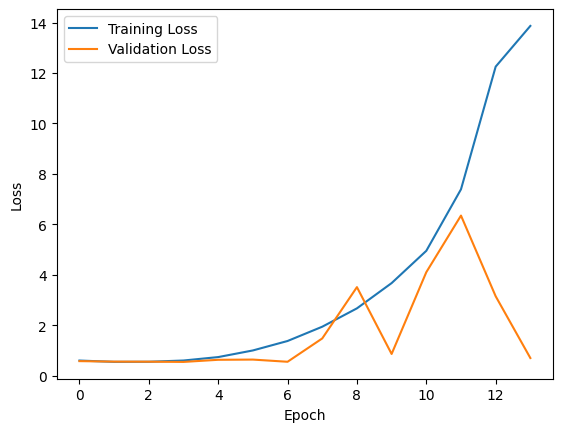

51/51 [==============================] - 1s 19ms/step - loss: 0.5000 - accuracy: 0.7742
Test accuracy BLSTM: 0.774213433265686


In [149]:
blstm = BLSTMModel();
model = blstm.fitting();

test_loss, test_acc = model.evaluate(feature_test, label_test)
print(f'Test accuracy BLSTM: {test_acc}')

In [158]:
from sklearn.metrics import confusion_matrix

from tensorflow.keras.metrics import Precision, Recall;
from tensorflow import argmax;

In [175]:
predictions = model.predict(feature_test);

# Convert predictions and true labels to class indices
predicted_classes = [];
true_classes = [];

for i in range(len(predictions)):
    prediction = numpy.argmax(predictions[i]);
    ground_truth = numpy.argmax(label_test[i]);
    predicted_classes.append(prediction);
    true_classes.append(ground_truth);

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Calculate precision and recall
precision = Precision()
recall = Recall()

precision.update_state(label_test, predictions)
recall.update_state(label_test, predictions)

precision_result = precision.result().numpy()
recall_result = recall.result().numpy()

print("Confusion Matrix:")
print(conf_matrix)
print("Precision:", precision_result)
print("Recall:", recall_result)

51/51 [==============================] - 1s 18ms/step
Confusion Matrix:
[[1255    0]
 [ 366    0]]
Precision: 0.50030845
Recall: 0.68903995
